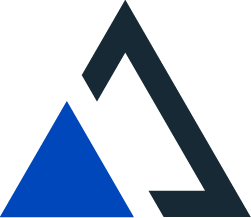

<h1><font color='#0047BB'>Semantic Predictions</font></h1>

<h3><font color='#0047BB'>Introduction</h3>

With Semantic Predictions, AI-Link users can write predictions generated in their Python environment back to the data warehouse as a new table. AtScale will assist in aggregating and joining these predictions at the warehouse level so that they’re consumable via BI tools.

Semantic Predictions accelerates MLOps processes, rapidly surfacing predictions in business stakeholders’ BI tools of choice. 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from atscale.client import Client
from atscale.base.enums import Aggs
from atscale.db.connections.snowflake import Snowflake

<h3><font color='#0047BB'>Connect to AtScale</h3>

In [3]:
client = Client(
    server=...,
    username=...,
    organization=...,
)

client.connect()

project = client.select_project(
    draft_project_id=...,
)

data_model = project.select_data_model()

Please choose a published project:
Automatically selecting only option: "ID: d33bda47-64f2-4600-5138-d9585e2620c0: Name: Sales Insights"
Please choose a data model:
Automatically selecting only option: "ID: b89a2fb7-74f4-4828-706e-70f7186e10a0: Name: Internet Sales Cube"


<h3><font color='#0047BB'>Connect to Data Warehouse</h3>

In [4]:
db = Snowflake(
    username=...,
    password=..., 
    account=..., 
    warehouse=..., 
    database=..., 
    schema=..., 
    warehouse_id=...,
)

<h3><font color='#0047BB'>Get Data From the AtScale Data Model</h3> 

For this example, we'll assume that we have week-wise customer count and sales data for years prior to 2008 (in `df_historic`), but only customer count data for 2008 (in `df_forecast`). 

Our goal is to forecast the sales data for 2008 with a predictive model, then write those predictions back to our AtScale data model.

In [5]:
df_historic = data_model.get_data(
    feature_list=[
        "Order Week",
        "customercount1",
        "salesamount1",
    ],
    filter_less={"Order ReportIng_Year": "Reporting Calendar 2008"}
)

df_forecast = data_model.get_data(
    feature_list=[
        "Order Week",
        "customercount1",
    ],
    filter_equals={"Order ReportIng_Year": "Reporting Calendar 2008"},
)

<h3><font color='#0047BB'>Train Your Model</h3> 

In the below cell, we train a linear regression model to forecast sales as a function of customer count.

In [6]:
# convert data to NumPy arrays
X = df_historic[["customercount1"]].to_numpy()

y = df_historic[["salesamount1"]].to_numpy()

# split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=7
)

# train model
regression_model = LinearRegression().fit(X_train, y_train)

# evaluate model on test data
print(f"R^2 score on test data: {regression_model.score(X_test, y_test)}")

R^2 score on test data: 0.7702678799414809


<h3><font color='#0047BB'>Generate Predictions With Your Model</h3> 

We'll now use the model we just trained to forecast sales for 2008, storing the values in `df_forecast` as the `PREDICTED SALESAMOUNT1` feature:

In [7]:
pred_feature_name = "PREDICTED SALESAMOUNT1"

m = regression_model.coef_.item()
b = regression_model.intercept_    

df_forecast[pred_feature_name] = m * df_forecast["customercount1"] + b

<h3><font color='#0047BB'>Write Predictions to AtScale</h3>  

We'll now create a table in our data warehouse with the DataFrame of predictions `df_forecast` and join it to the existing data model. AI-Link makes this possible in a single function call, where we name the new table of predictions `SALESAMOUNT1_FORECAST`.

In [8]:
pred_table_name = "SALESAMOUNT1_FORECAST"

In [9]:
data_model.writeback(
    dbconn=db,
    table_name=pred_table_name,
    dataframe=df_forecast,
    join_features=["Week"],
    join_columns=["Order Week"],
    roleplay_features=["Order"]
)

/Users/patrickmcdonald/GitHub/python-api/atscale/db/connections/snowflake.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[colV] = dataframe[colV].dt.date
09/05/2024 03:28:51 PM WARNING:Column name: Order Week appears as ORDER WEEK
09/05/2024 03:28:51 PM WARNING:Column name: customercount1 appears as CUSTOMERCOUNT1
09/05/2024 03:28:51 PM WARNING:Column name: week appears as WEEK
/Users/patrickmcdonald/GitHub/python-api/atscale/db/connections/snowflake.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

<h3><font color='#0047BB'>Make Predictions Consumable via BI Tools</h3> 

We can now create an aggregate feature based off of the predictions. This makes the predictions consumable in BI tools in addition to our Python environment.

In [10]:
data_model.create_aggregate_feature(
    fact_dataset_name=pred_table_name,
    column_name=pred_feature_name,
    new_feature_name="PREDICTED_SALES",
    aggregation_type=Aggs.SUM
)